# Calculate SEM Image Stats

See the [README](./README.md) for more details.

In [232]:
%matplotlib inline

import glob
import numpy
import matplotlib.pyplot
import scipy.ndimage
import pytesseract
import PIL.Image
from toolz.curried import map, pipe, compose, get, do, curry, count, pluck, juxt, flip
import pandas
import skimage
import skimage.measure
import skimage.filters
import skimage.morphology

 ## Helper Functions

`fcompose` is a helper function that doesn't seem to be in Toolz, but seems to make writing function pipelines much easier, likewise, when working with lists of dictionaries and data frames, `mapdict` and `dfassing` seem useful.

In [30]:
fcompose = lambda *args: compose(*args[::-1])

mapdict = lambda **kwargs: map(lambda data: dict(**dict((k, f(data)) for k, f in kwargs.items()),
                                                 **data))

@curry
def dfassign(df, **kwargs):
    return df.assign(**dict(((k, f(df)) for k, f in kwargs.items())))

## View the Images

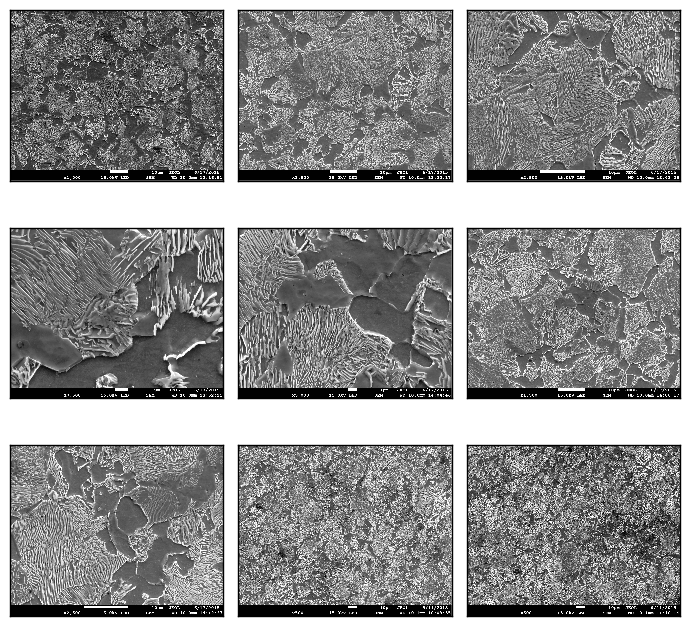

In [31]:
reshape = lambda arr: arr if len(arr.shape) == 2 else arr[...,0]
to_array = lambda image: reshape(numpy.asarray(image.convert("L")))

def plt_arrays(arrs):
    """Plot a set of (n, n) arrays as row column sub plots.
    """
    fig = matplotlib.pyplot.figure(figsize=(7, 7))
    N = int(numpy.ceil(numpy.sqrt(len(arrs))))
    for i, arr in enumerate(arrs):
        ax = fig.add_subplot(N, N, i + 1)
        out = ax.imshow(arr, cmap='Greys_r', interpolation='none')
        out.axes.get_xaxis().set_visible(False)
        out.axes.get_yaxis().set_visible(False)
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

_ = pipe(
    'data/*.tif',
    glob.glob,
    sorted,
    map(PIL.Image.open),
    map(to_array),
    list,
    plt_arrays
)

## Extract the Metadata

Each image has metadata embedded in the image. Here, `pytesseract` is used to extract this data. The images are cropped to split them into two upper and lower sections. The text extraction works better without the microstructure noise.

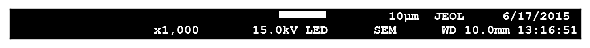

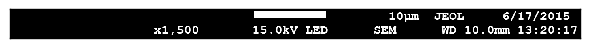

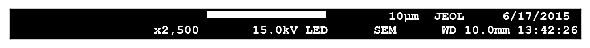

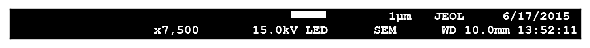

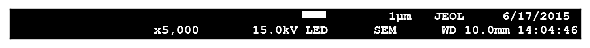

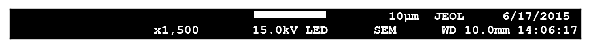

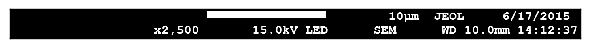

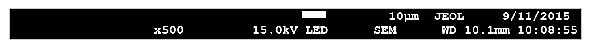

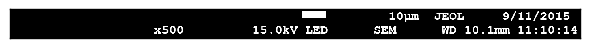

In [32]:
@curry
def crop_image(image, cutoff=960):
    """Crop the images into the "upper" and "lower" portions.

    Splits the image into the actual image of the microstructure and the embedded metadata.

    Args:
      image: a PIL image
      cutoff: the cutoff height for the upper image

    Returns:
      {'upper' : upper_image, 'lower': lower_image}
    """
    return dict(
               upper=image.crop(box=(0, 0, image.size[0], cutoff)),
               lower=image.crop(box=(0, cutoff, image.size[0], image.size[1]))
           )

def plt_array(arr):
    """Plot a single 2D array
    """
    ax = matplotlib.pyplot.imshow(arr, cmap='Greys_r', interpolation='none')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

_ = pipe(
    'data/*.tif',
    glob.glob,
    sorted,
    map(PIL.Image.open),
    map(crop_image),
    pluck('lower'),
    map(to_array),
    map(
        do(
            plt_array
        )
    ),
    list
)

The metadata required from the images is the scale of the images. This requires the real scale size given by the number to the right of the scale bar and the size of the scale bar in pixels.

In [69]:
repair_string = lambda string: float('10' if string == 'mum' else string.replace('pm', ''))

scale_pixels = fcompose(
    to_array,
    lambda data: skimage.measure.label(data, background=0),
    skimage.measure.regionprops,
    get(1),
    lambda data: data.bbox[3] - data.bbox[1],
)

extract_strings = fcompose(
    lambda image: pytesseract.image_to_string(image),
    lambda string: string.split(),
    get([1, 3, -1]),
    lambda data: dict(scale_microns=repair_string(data[0]),
                      date=data[1].replace('-', ''),
                      time=data[2])
)

extract_metadata = fcompose(
    PIL.Image.open,
    crop_image,
    get('lower'),
    lambda image: dict(scale_pixels=scale_pixels(image), **extract_strings(image))
)

print(pipe(
    'data/*.tif',
    glob.glob,
    sorted,
    map(
        lambda filename: dict(filename=filename, **extract_metadata(filename))
    ),
    list,
    pandas.DataFrame
))

        date                            filename  scale_microns  scale_pixels  \
0  6/17/2015   data/1045_Steel_Nital-etch-01.tif           10.0           107   
1  6/17/2015   data/1045_Steel_Nital-etch-02.tif           10.0           161   
2  6/17/2015   data/1045_Steel_Nital-etch-03.tif           10.0           267   
3  6/17/2015   data/1045_Steel_Nital-etch-04.tif            1.0            80   
4  6/17/2015   data/1045_Steel_Nital-etch-05.tif            1.0            54   
5  6/17/2015   data/1045_Steel_Nital-etch-06.tif           10.0           161   
6  6/17/2015   data/1045_Steel_Nital-etch-07.tif           10.0           267   
7  9/11/2015   data/20150911_1045_Nital_etch.tif           10.0            54   
8  9/11/2015  data/20150911_1045_Nital_etch2.tif           10.0            54   

       time  
0  13:16:51  
1  13:20:17  
2  13:42:26  
3  13:52:11  
4  14:04:46  
5  14:06:17  
6  14:12:37  
7  10:08:55  
8  11:10:14  


## Rescale the Images

An array data point needs to have the same representation across all the images. This is done by rescaling the all the images to have the scale of the coarsest sampling. This isn't currently used for any later analysis, but is an intersting use of data analysis and shows how to pass dataframes and dictionaries through the function pipelines.

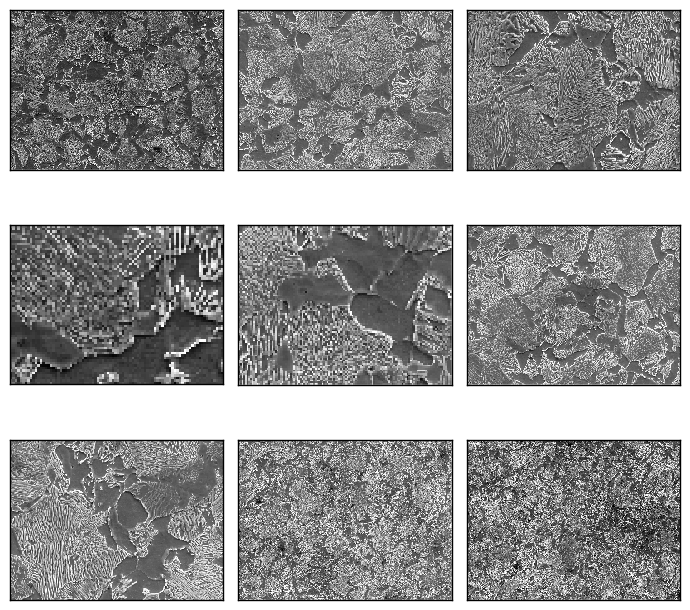

In [34]:
extract_image = fcompose(
    PIL.Image.open,
    crop_image,
    get('upper')
)

def scale_image(image, rescale_factor):
    """Scale the image using PIL's thumbnail

    thumbnail is an inplace operation so copies are required.

    Args:
      image: a PIL image
      rescale_factor: how much to rescale the image by

    Returns:
      a new image
    """
    copy_image = image.copy()
    copy_image.thumbnail(numpy.array(copy_image.size) * rescale_factor, PIL.Image.ANTIALIAS)
    return copy_image

get_df = fcompose(
    glob.glob,
    sorted,
    map(
        lambda filename: dict(filename=filename,
                              **extract_metadata(filename))
    ),
    list,
    pandas.DataFrame,
    dfassign(pixel_size=lambda df: df['scale_microns'] / df['scale_pixels']),
    dfassign(rescale_factor=lambda df: df['pixel_size'] / max(df['pixel_size'])),
)

scaled_images = fcompose(
    get_df,
    lambda df: df.T.to_dict().values(),
    mapdict(image=lambda data: extract_image(data['filename'])),
    mapdict(scaled_image=lambda data: scale_image(data['image'], data['rescale_factor'])),
    list
)

_ = pipe(
    'data/*.tif',
    scaled_images,
    pluck('scaled_image'),
    map(to_array),
    list,
    plt_arrays
)

## Threshold the images into the ferrite and cementite phase

The following reads in the image and uses [Otsu's algorithm](https://en.wikipedia.org/wiki/Otsu%27s_method) to threshold the images.

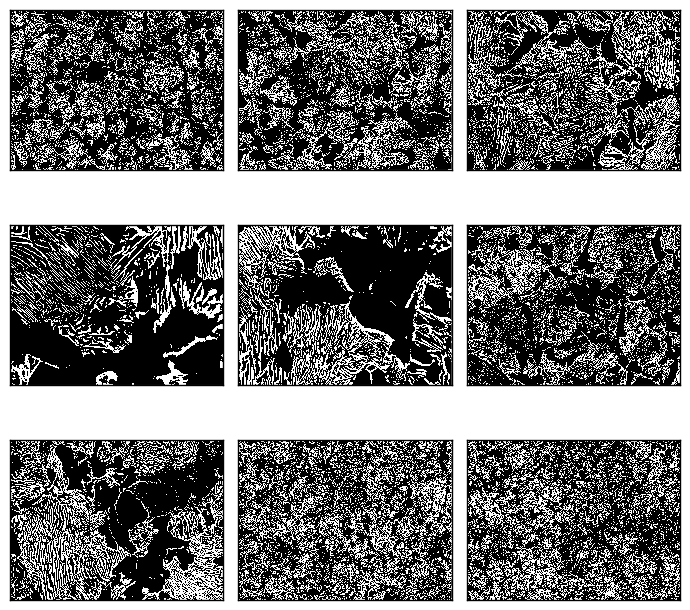

In [94]:
threshold_image = fcompose(
    PIL.Image.open,
    crop_image,
    get('upper'),
    to_array,
    lambda data: data > skimage.filters.threshold_otsu(data)
)

_ = pipe('data/*.tif',
     glob.glob,
     sorted,
     map(threshold_image),
     list,
     plt_arrays
)

## Remove White Specs

One aspect of cleaning up the noise is to remove the small white specs that occur in the image. According to domain experts, these are not real and are probably caused by the thresholding or image noise. The function `skimage.morphology.remove_small_holes` does that. It removes islands of 0s in a matrix of 1s. We need to remove 1s in a matrix of 1s so we use the not operator, `~`, on both ends of the calculation.

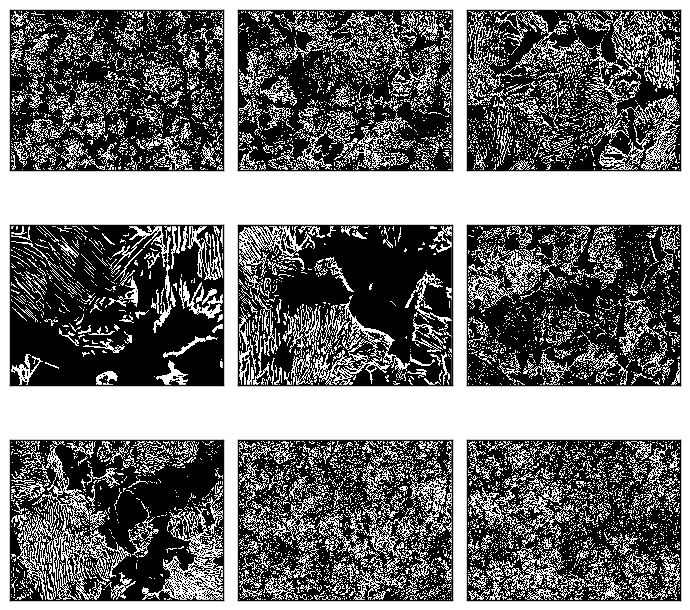

In [215]:
def f_min_size(scale_microns, scale_pixels, island_size=0.2):
    return (island_size * scale_pixels / scale_microns)**2

_ = pipe('data/*.tif',
    glob.glob,
    sorted,
    map(
        lambda filename: dict(image=threshold_image(filename),
                              **extract_metadata(filename))
    ),
    mapdict(min_size=lambda d: f_min_size(d['scale_microns'], d['scale_pixels'])),
    map(
        lambda d: ~skimage.morphology.remove_small_holes(~d['image'],
                                                          d['min_size'])
    ),
    list,
    plt_arrays
)

## Binary Closing to Reveal The Pearlite Phase

The next part of the analysis reveals the pearlite phase by using a [binary closing](http://homepages.inf.ed.ac.uk/rbf/HIPR2/close.htm), a dilation followed by erosion. This removes the long ferrite spacing in the pearlite. We're using [`skimage.morphology.closing`](http://tonysyu.github.io/scikit-image/api/skimage.morphology.html#skimage.morphology.closing).

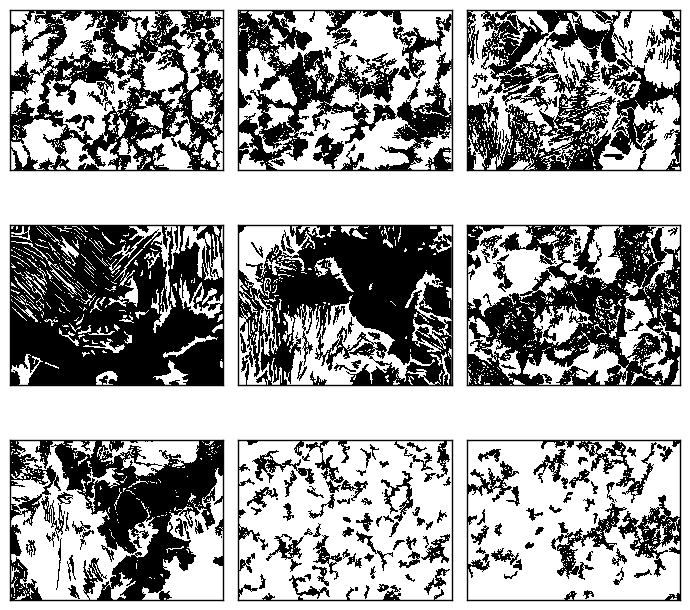

In [242]:
closing = curry(flip(skimage.morphology.closing))
remove_small_holes = curry(skimage.morphology.remove_small_holes)

reveal_pearlite = fcompose(
    closing(skimage.morphology.square(5)),
    remove_small_holes(min_size=1000)
)

_ = pipe('data/*.tif',
    glob.glob,
    sorted,
    map(
        lambda filename: dict(image=threshold_image(filename),
                              **extract_metadata(filename))
    ),
    mapdict(min_size=lambda d: f_min_size(d['scale_microns'], d['scale_pixels'])),
    map(
        lambda d: ~remove_small_holes(~d['image'], d['min_size'])
    ),
    map(reveal_pearlite),
    list,
    plt_arrays
)

## Volume Fractions

In [253]:
frac1 = lambda image: image.sum() / image.size
frac0 = lambda image: 1 - frac1(image)

print(pipe('data/*.tif',
    glob.glob,
    sorted,
    map(
        lambda filename: dict(filename=filename,
                              threshold_image=threshold_image(filename),
                              **extract_metadata(filename))
    ),
    mapdict(
        min_size=lambda d: f_min_size(d['scale_microns'], d['scale_pixels'])),
    mapdict(
        clean_image=lambda d: ~remove_small_holes(~d['threshold_image'], d['min_size'])
    ),
    mapdict(
        pearlite_image=lambda d: reveal_pearlite(d['clean_image'])
    ),
    mapdict(
        pearlite_fraction=lambda data: frac1(data['pearlite_image']),
        ferrite_fraction=lambda data: frac0(data['clean_image']),
        cemmentite_fraction=lambda data: frac1(data['clean_image'])
    ),
    list,
    pandas.DataFrame
)[['filename', 'pearlite_fraction', 'ferrite_fraction', 'cemmentite_fraction']])

                             filename  pearlite_fraction  ferrite_fraction  \
0   data/1045_Steel_Nital-etch-01.tif           0.540794          0.749158   
1   data/1045_Steel_Nital-etch-02.tif           0.561536          0.729814   
2   data/1045_Steel_Nital-etch-03.tif           0.510295          0.702441   
3   data/1045_Steel_Nital-etch-04.tif           0.211591          0.809500   
4   data/1045_Steel_Nital-etch-05.tif           0.343964          0.748475   
5   data/1045_Steel_Nital-etch-06.tif           0.449462          0.768789   
6   data/1045_Steel_Nital-etch-07.tif           0.502832          0.703425   
7   data/20150911_1045_Nital_etch.tif           0.787591          0.667285   
8  data/20150911_1045_Nital_etch2.tif           0.781052          0.687852   

   cemmentite_fraction  
0             0.250842  
1             0.270186  
2             0.297559  
3             0.190500  
4             0.251525  
5             0.231211  
6             0.296575  
7             0.332